In [245]:
import mujoco
import mujoco.viewer
import numpy as np
from tqdm import tqdm
import time


In [246]:
class PID:
    def __init__(self, kp, ki, kd, i_limit=np.inf):
        self.kp, self.ki, self.kd = kp, ki, kd
        self.i_limit = i_limit
        self.prev_error = 0.0
        self.integral = 0.0

    def reset(self):
        self.prev_error = 0.0
        self.integral = 0.0

    def compute(self, error, dt):
        self.integral += error * dt
        self.integral = np.clip(self.integral, -self.i_limit, self.i_limit)
        derivative = (error - self.prev_error) / dt if dt > 0 else 0
        self.prev_error = error
        return self.kp * error + self.ki * self.integral + self.kd * derivative


def quaternion_to_euler(q):
    w, x, y, z = q
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    roll = np.arctan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = np.clip(t2, -1.0, 1.0)
    pitch = np.arcsin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    yaw = np.arctan2(t3, t4)

    return np.array([roll, pitch, yaw])

In [358]:
def motion_control(model, data):
    global target_y, target_z, target_vx, target_yaw
    dt = model.opt.timestep
    
    if data.sensor("straight_lidar").data[0] < 5 and data.sensor("straight_lidar").data[0] != -1:
        target_z = 2
        
    if data.sensor("upper_lidar").data[0] < 2 and data.sensor("upper_lidar").data[0] != -1:
        target_z = 3
    
    current_y = data.qpos[1]
    e_y = target_y - current_y
    roll_target = y_pid.compute(e_y, dt)
    
    current_z = data.qpos[2]
    error_z = target_z - current_z
    thrust = z_pid.compute(error_z, dt)

    current_vx = data.qpos[0]
    e_vx = target_vx - current_vx
    pitch_target = vx_pid.compute(e_vx, dt)

    quat = data.sensor('body_quat').data
    rpy = quaternion_to_euler(quat)

    pitch_target = np.clip(pitch_target, -0.3, 0.3)
    e_pitch = pitch_target - rpy[1]
    pitch_control = pitch_pid.compute(e_pitch, dt)
    pitch_control = np.clip(pitch_control, -0.5, 0.5)
    
    roll_target = np.clip(roll_target, -0.2, 0.2)
    roll_control = roll_pid.compute(roll_target - rpy[0], dt)
    roll_control = np.clip(roll_control, -0.5, 0.5)
    
    yaw_control = yaw_pid.compute(target_yaw - rpy[2], dt)
    yaw_control = np.clip(yaw_control, -0.5, 0.5)
    
    ctrl_range = [-13, 13]
    # u1 = np.clip(thrust - roll_control + pitch_control - yaw_control, *ctrl_range) # задний правый
    # u2 = np.clip(thrust + roll_control + pitch_control + yaw_control, *ctrl_range) # задний левый
    # u3 = np.clip(thrust - roll_control - pitch_control + yaw_control, *ctrl_range) # передний левый
    # u4 = np.clip(thrust + roll_control - pitch_control - yaw_control, *ctrl_range) # передний правый
    
    # u1 = np.clip(thrust - roll_control, *ctrl_range) # задний правый
    # u2 = np.clip(thrust + roll_control, *ctrl_range) # задний левый
    # u3 = np.clip(thrust + roll_control, *ctrl_range) # передний левый
    # u4 = np.clip(thrust - roll_control, *ctrl_range) # передний правый
    
    u1 = np.clip(thrust - roll_control + pitch_control, *ctrl_range) # задний правый
    u2 = np.clip(thrust + roll_control + pitch_control, *ctrl_range) # задний левый
    u3 = np.clip(thrust + roll_control - pitch_control, *ctrl_range) # передний левый
    u4 = np.clip(thrust - roll_control - pitch_control, *ctrl_range) # передний правый
    
    
    data.ctrl = [u1, u2, u3, u4]
    
    # Логируем дату
    
    output["vx"].append(data.qvel[0])
    output["vy"].append(data.qvel[1])
    output["vz"].append(data.qvel[2])
    output["x"].append(data.qpos[0])
    output["y"].append(data.qpos[1])
    output["z"].append(data.qpos[2])
    
    output["roll"].append(rpy[0])
    output["pitch"].append(rpy[1])
    output["yaw"].append(rpy[2])
    
    output["roll_ctrl"].append(roll_control)
    output["pitch_ctrl"].append(pitch_control)
    output["yaw_ctrl"].append(yaw_control)
    
    u["left_forward"].append(u1)
    u["right_forward"].append(u2)
    u["right_back"].append(u3)
    u["left_back"].append(u4)
    
    
    

In [359]:
mujoco.set_mjcb_control(None)
model = mujoco.MjModel.from_xml_path("scene.xml")
data = mujoco.MjData(model)

mujoco.set_mjcb_control(motion_control)


# z_pid = PID(kp=7, ki=2, kd=5.5)
# vx_pid = PID(kp=7, ki=2, kd=5.5)
# y_pid = PID(kp=0.3, ki=0.01, kd=0.1)
# 
# roll_pid = PID(kp=5.5, ki=0.45, kd=1.5)
# pitch_pid = PID(kp=5.5, ki=0.45, kd=1.5)
# yaw_pid = PID(kp=5.5, ki=0.45, kd=1.5)

z_pid = PID(kp=7, ki=2, kd=5.5)
y_pid = PID(kp=1, ki=1, kd=1)
vx_pid = PID(kp=0.3, ki=0.01, kd=0.1)

roll_pid = PID(kp=1, ki=1, kd=1)
pitch_pid = PID(kp=5.5, ki=0.45, kd=1.5)
yaw_pid = PID(kp=5.5, ki=0.45, kd=1.5)


target_y = 3   # [м]
target_z = 3    # [м]
target_vx = 3   # [м/c]
target_yaw = 0  # [рад]

output = {"x": [], "y": [], "z": [],
          "vx": [], "vy": [], "vz": [],
          "roll": [], "pitch": [], "yaw": [],
          "roll_ctrl": [], "pitch_ctrl": [], "yaw_ctrl": []}

u = {"left_forward": [], "right_forward": [], "right_back": [], "left_back": []}
t = []
first = True

# with mujoco.viewer.launch_passive(model, data) as viewer:
#     viewer.cam.distance = 8        
#     viewer.cam.azimuth = 30   
#     viewer.cam.elevation = -20 
#     while viewer.is_running():
#         if first:
#             time.sleep(1)
#             first = False
#         mujoco.mj_step(model, data)
#         time.sleep(0.01)
#         viewer.cam.lookat = data.qpos[0:3]
#         viewer.sync() 

end_time = 60 # в секундах
step = model.opt.timestep
for i in tqdm(range(int(end_time / step))):
    mujoco.mj_step(model, data)
    t.append(round(i * step, 2))
        

100%|██████████| 6000/6000 [00:00<00:00, 13996.88it/s]


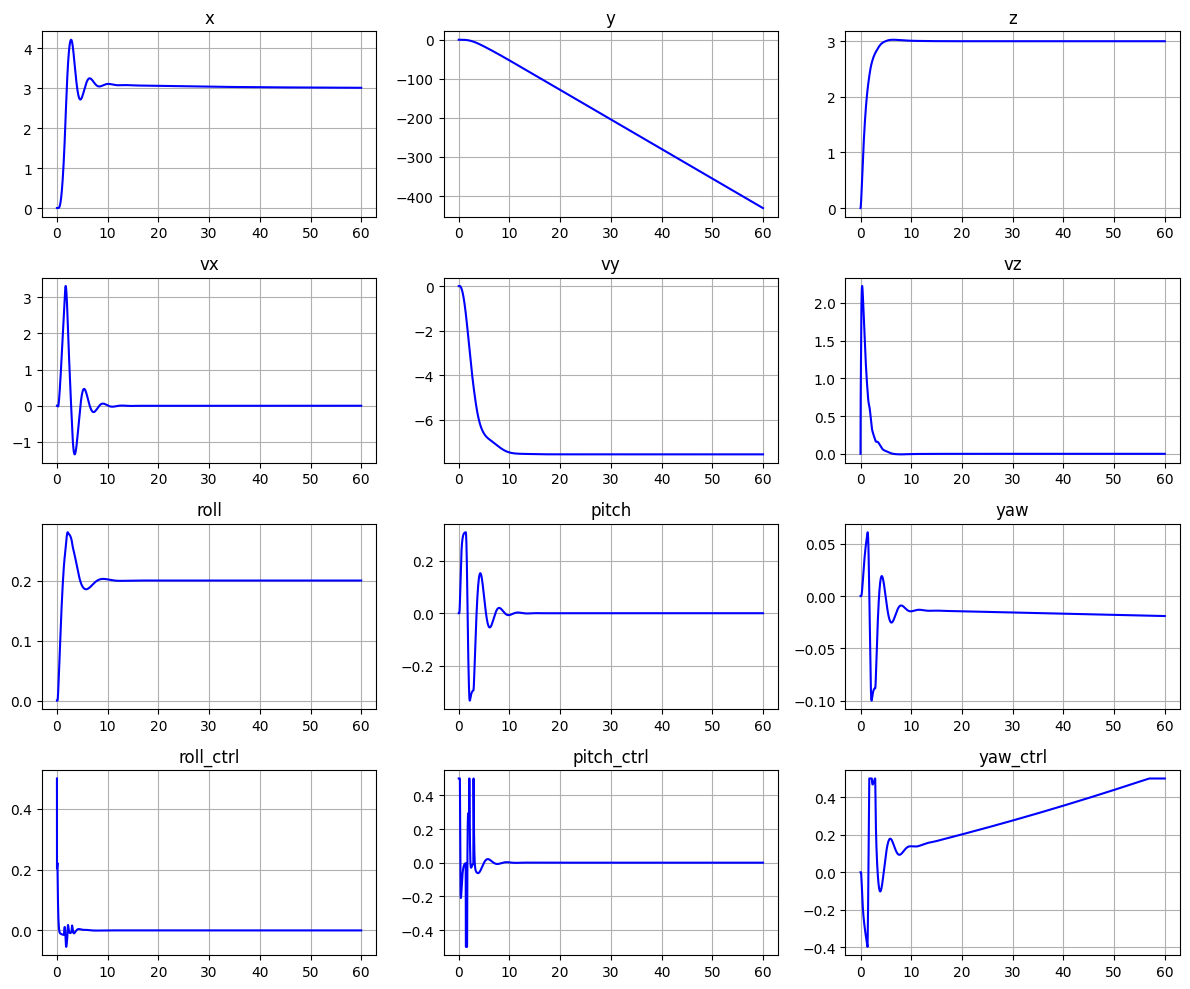

In [360]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 10))
i, j = 0, 0

for k, v in output.items():
    axes[i, j].plot(t, v, color='blue')
    axes[i, j].set_title(k)
    axes[i, j].grid()
    j += 1
    if j > 2:
        i += 1
        j = 0  
        
fig.tight_layout()
    

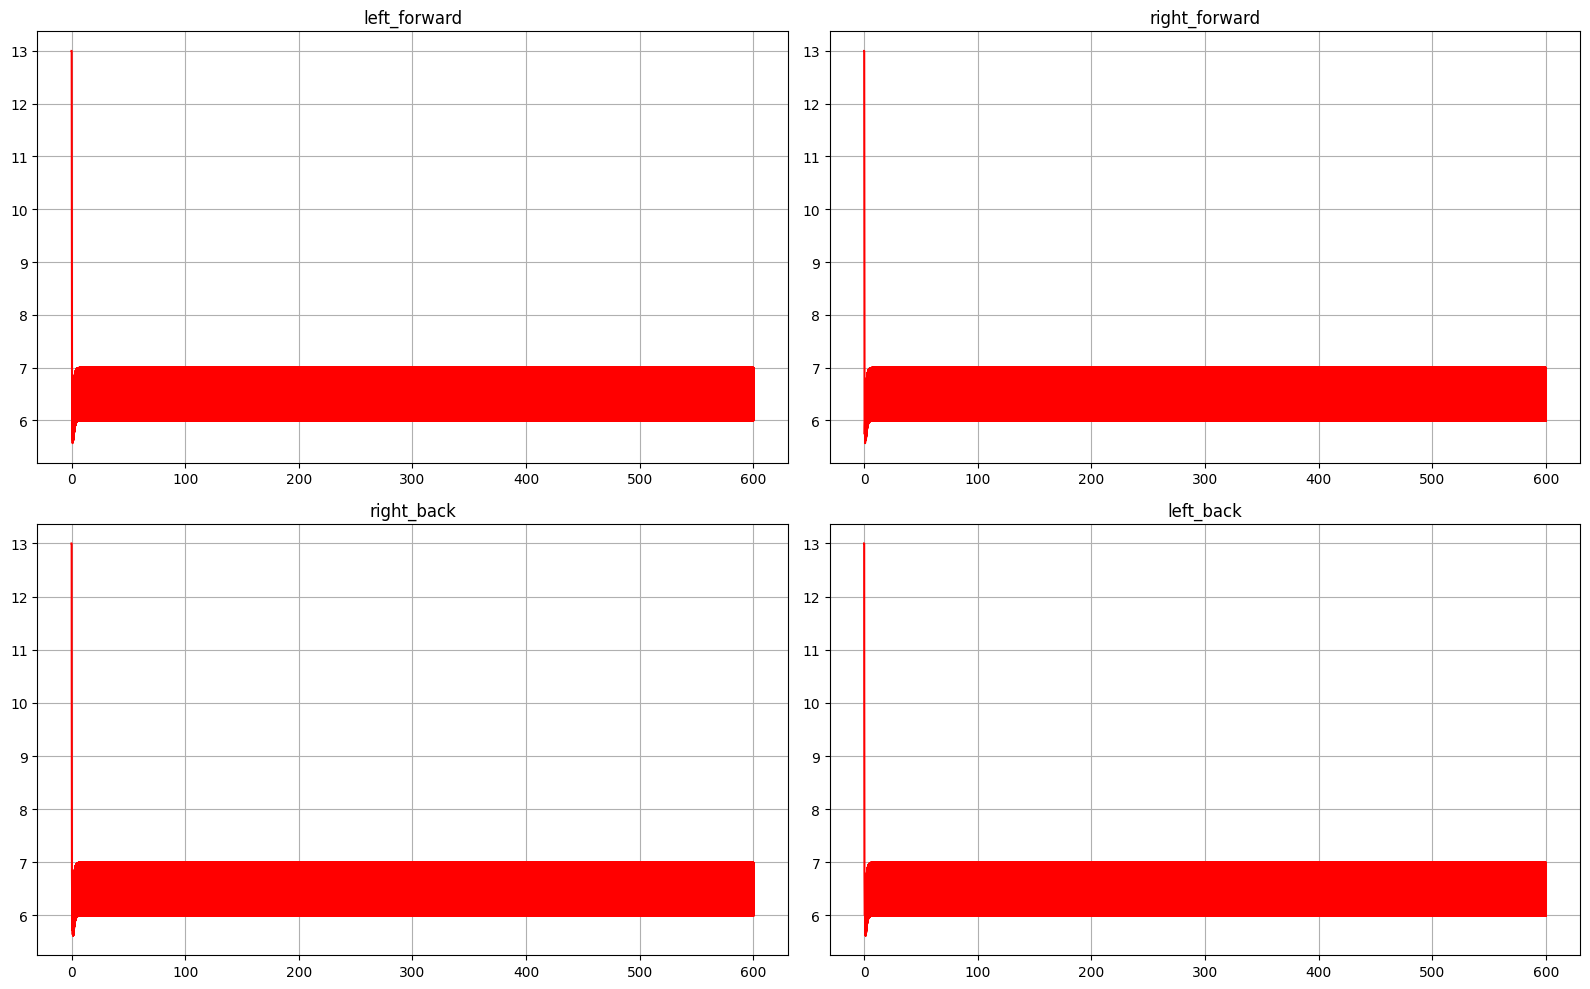

In [122]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

i, j = 0, 0
for k, v in u.items():
    axes[i, j].plot(t, v, color='red')
    axes[i, j].set_title(k)
    axes[i, j].grid()
    j += 1
    if j > 1:
        i += 1
        j = 0
fig.tight_layout()